## Landsat Collection Cloud Cover 

This tutorial demonstrates the recommended methodology for using the `qa_pixel` band of the Landsat collection

### Background

Clouds 
    
**Notes**:
- This example uses [landsat-c2-l2 data](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)

In [1]:
import stackstac
import pystac_client
from pystac.extensions.eo import EOExtension as eo
import pyproj
import planetary_computer as pc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import dask
from dask_gateway import GatewayCluster

import ipyleaflet
import IPython.display as dsp
import geogif

In [2]:
lat, lon = -17.9, 25.8
m = ipyleaflet.Map(scroll_wheel_zoom=True)
m.center = lat, lon
m.zoom = 12
m.layout.height = "800px"
m

Map(center=[-17.9, 25.8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [3]:
bbox = (m.west, m.south, m.east, m.north)
bbox

(25.599174499511722,
 -18.030648287647548,
 26.000518798828125,
 -17.7692853035414)

In [4]:
catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

In [235]:
search = catalog.search(filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "s_intersects", "args": [{"property": "geometry"}, bbox]},
    {"op": "anyinteracts", "args": [{"property": "datetime"}, "2021-04-01/2021-07-01"]},
    {"op": "=", "args": [{"property": "collection"}, "landsat-c2-l2"]},
    {"op": "!=", "args": [{"property": "platform"}, "landsat-7"]},
    {"op": "lt", "args": [{"property": "eo:cloud_cover"}, 50]}
  ]
})

In [97]:
# search = catalog.search(
#     collections=['landsat-c2-l2'],
#     bbox=bbox,
#     datetime="2021-04-01/2022-05-01",
#     query={"eo:cloud_cover": {"lt": 50}},
# )

In [236]:
items = pc.sign(search)

len(items)

10

In [237]:
item = max(items, key=lambda item: eo.ext(item).cloud_cover)

In [245]:
stack = stackstac.stack(
    [item.to_dict()], 
    assets=["qa_pixel"], 
    dtype="uint16", 
    fill_value=0
).isel(band=0)
stack

<xarray.DataArray 'stackstac-e9afdf568ab02ac5c472b576c5bad92b' (time: 1,
                                                                y: 7722, x: 7612)>
dask.array<getitem, shape=(1, 7722, 7612), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/29)
  * time                         (time) datetime64[ns] 2021-04-30T08:18:01.52...
    id                           (time) <U31 'LC08_L2SP_173072_20210430_02_T1'
    band                         <U8 'qa_pixel'
  * x                            (x) float64 2.697e+05 2.697e+05 ... 4.98e+05
  * y                            (y) float64 -1.802e+06 ... -2.034e+06
    landsat:wrs_type             <U1 '2'
    ...                           ...
    landsat:cloud_cover_land     float64 33.89
    landsat:correction           <U4 'L2SP'
    sci:doi                      <U16 '10.5066/P9OGBGM6'
    title                        <U29 'Pixel Quality Assessment Band'
    raster:bands                 object {'unit': 'bit index', 'nodata': 1, 'd...
    epsg                         int64 32635
Attributes:
    spec:        RasterSpec(epsg=32635, bounds=(269670.0, -2034030.0, 498030....
    crs:         epsg:32635
    transform:   | 30.00, 0.00, 269670.00|\n| 0.00,-30.00,-1802370.00|\n| 0.0...
    resolution:  30.0

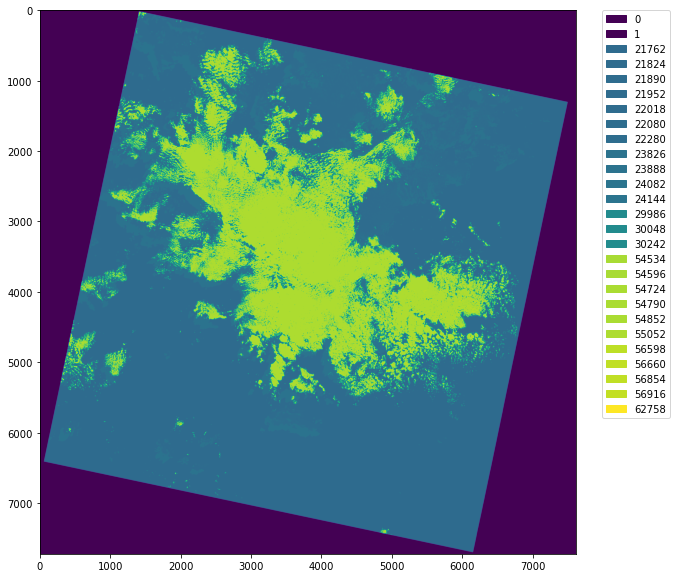

In [239]:
image = stack.data.squeeze().compute()

plt.figure(figsize=(10,10))
im = plt.imshow(image)
values = np.unique(image.ravel())
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{values[i]}") for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

In [240]:
# Make a cloud mask for the values you care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bad = stack & bitmask  # just look at those 4 bits
mask = bad == 0

In [241]:
good = stack.where(bad == 0)  # mask pixels where any one of those bits are set

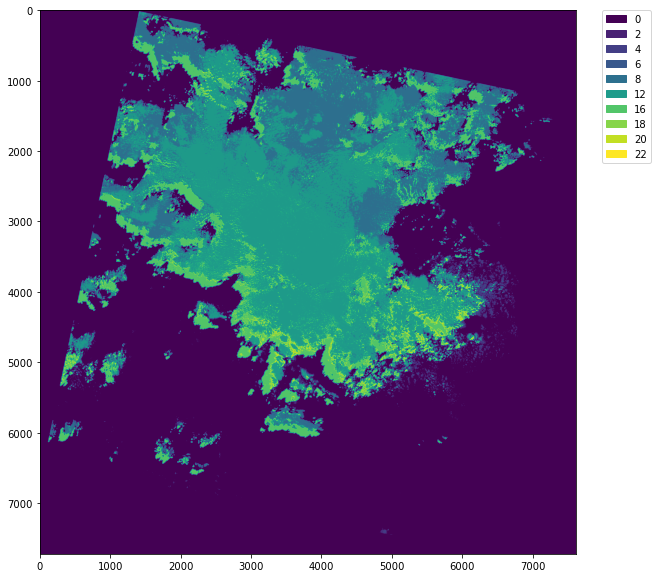

In [242]:
image = bad.data.squeeze().compute()

plt.figure(figsize=(10,10))
im = plt.imshow(image)
values = np.unique(image.ravel())
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{values[i]}") for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

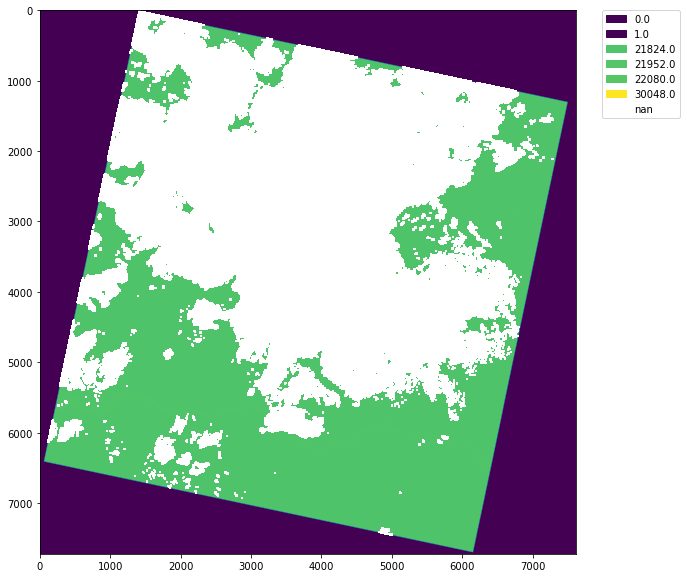

In [243]:
image = good.data.squeeze().compute()

plt.figure(figsize=(10,10))
im = plt.imshow(image)
values = np.unique(image.ravel())
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{values[i]}") for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

In [244]:
cloudy_pix = np.isnan(image).sum()/(image.shape[0] * image.shape[1])
cloudy_pix

0.330571384105278

In [219]:
search = catalog.search(filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "s_intersects", "args": [{"property": "geometry"}, bbox]},
    {"op": "anyinteracts", "args": [{"property": "datetime"}, "2021-01-01/2022-01-01"]},
    {"op": "=", "args": [{"property": "collection"}, "landsat-c2-l2"]},
    {"op": "=", "args": [{"property": "platform"}, "landsat-7"]},
    {"op": "lt", "args": [{"property": "eo:cloud_cover"}, 50]}
  ]
})
items = pc.sign(search)

len(items)

34

In [220]:
item = max(items, key=lambda item: eo.ext(item).cloud_cover)

In [261]:
stack = stackstac.stack(
    [item.to_dict()], 
    assets=["qa_pixel"], 
    dtype="uint16", 
    fill_value=0
).isel(band=0)

# Make a cloud mask for the values you care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

'0b11110'

In [229]:
bad = stack & bitmask  # just look at those 4 bits
mask = bad == 0
good = stack.where(bad == 0)  # mask pixels where any one of those bits are set

In [254]:
x_utm, y_utm = pyproj.Proj(stack.crs)(lon, lat)

buffer = 10000  # meters

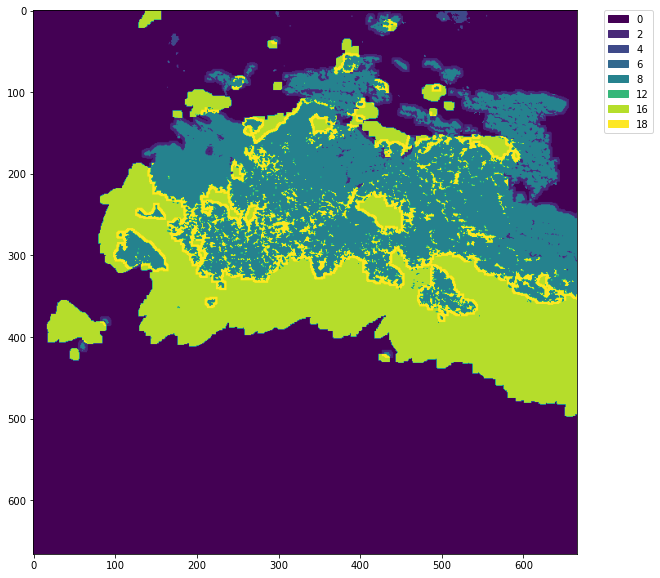

In [255]:
aoi = bad.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
image = aoi.data.squeeze().compute()

plt.figure(figsize=(10,10))
im = plt.imshow(image)
values = np.unique(image.ravel())
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{values[i]}") for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

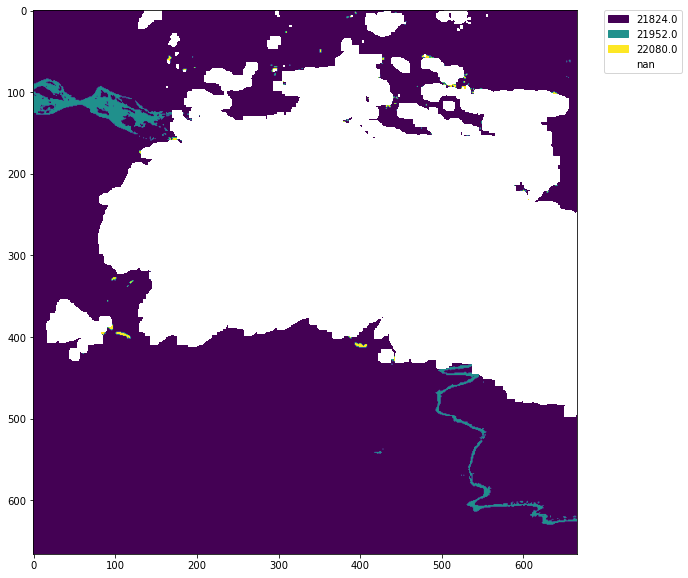

In [256]:
aoi = good.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
image = aoi.data.squeeze().compute()

plt.figure(figsize=(10,10))
im = plt.imshow(image)
values = np.unique(image.ravel())
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{values[i]}") for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

In [257]:
image.shape

(666, 666)

In [258]:
np.isnan(image).sum()

175041

In [259]:
(image.shape[0] * image.shape[1])

443556

In [260]:
cloudy_pix = np.isnan(image).sum()/(image.shape[0] * image.shape[1])
cloudy_pix

0.3946311176040906

In [2]:
import warnings
import time
import os
import gc
import calendar
import re

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyhere import here

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from scipy import ndimage as nd

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas
import dask_geopandas
from dask.distributed import Client

from pystac import Item
import stackstac
import pyproj

warnings.filterwarnings(action="ignore", category=UserWarning, module="torch")
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=RuntimeWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)

import pystac_client
import planetary_computer as pc


# Disabling the benchmarking feature with torch.backends.cudnn.benchmark = False 
# causes cuDNN to deterministically select an algorithm, possibly at the cost of reduced performance.
# https://pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.benchmark = False

np.random.seed(42)
torch.manual_seed(42)

import random
random.seed(42)

## Set Parameters

In [3]:
num_features = 1024
country_code = 'ZMB'
use_file = True
# use_file = False

In [93]:
satellite = "landsat-c2-l2"
# bands = ["qa_pixel"]
bands = ['cloud_qa']

In [5]:
if satellite == "landsat-c2-l2":
    resolution = 30
    min_image_edge = 6
else:
    resolution = 10
    min_image_edge = 20

## Create grid and sample points to featurize

In [94]:
if use_file:
    gdf = pd.read_feather(here('data', 'grid', 'ZMB_crop_weights_20k-points.feather'))
    gdf = (
        geopandas
        .GeoDataFrame(
            gdf, 
            geometry = geopandas.points_from_xy(x = gdf.lon, y = gdf.lat), 
            crs='EPSG:4326')
    )
else:
    cell_size = 0.01  # Roughly 1 km
    ### get country shape
    country_file_name = f"data/geo_boundaries/africa_adm0.geojson"
    africa = geopandas.read_file(country_file_name)
    country = africa[africa.adm0_a3 == country_code]
    #### This would be simpler, but throws an error down the line if used 
    # world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    # country = world.query(f'iso_a3 == "{country_code}"')
    ### Create grid of points
    cell_size = .01  # Very roughly 1 km
    xmin, ymin, xmax, ymax = country.total_bounds
    xs = list(np.arange(xmin, xmax + cell_size, cell_size))
    ys = list(np.arange(ymin, ymax + cell_size, cell_size))
    def make_cell(x, y, cell_size):
        ring = [
            (x, y),
            (x + cell_size, y),
            (x + cell_size, y + cell_size),
            (x, y + cell_size)
        ]
        cell = shapely.geometry.Polygon(ring).centroid
        return cell
    center_points = []
    for x in xs:
        for y in ys:
            cell = make_cell(x, y, cell_size)
            center_points.append(cell)
    ### Put grid into a GeDataFrame for cropping to country shape
    gdf = geopandas.GeoDataFrame({'geometry': center_points}, crs = 'EPSG:4326')
    gdf['lon'], gdf['lat'] = gdf.geometry.x, gdf.geometry.y
    ### Subset to country 
    ### This buffer ensures that no points are take at the border 
    ### which would lead to duplication with neighboring countries
    gdf = gdf[gdf.within(country.unary_union.buffer(-0.005))]
    gdf = gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)
    gdf = gdf.sample(frac = 0.1, random_state=42, ignore_index=False)
    points = gdf[["lon", "lat"]].to_numpy()
pt_len = gdf.shape[0]
gdf.shape

(19598, 4)

In [95]:
NPARTITIONS = 250

ddf = dask_geopandas.from_geopandas(gdf, npartitions=1)
hd = ddf.hilbert_distance().compute()
gdf["hd"] = hd
gdf = gdf.sort_values("hd")

dgdf = dask_geopandas.from_geopandas(gdf, npartitions=NPARTITIONS, sort=False)

del ddf
del hd
del gdf
gc.collect()

41589

In [144]:
start_month = 7

year_start = 2022
year_end = 2022

buffer_size = 0.005
cloud_limit = 20

batch_size = 1

workers = os.cpu_count() 

print(
   f"""
    Using:  
        Satellite: {satellite}  
        Pixel Resolution: {resolution}  
        Grid Resolution: {buffer_size * 2} degree squared (WGS84) 
        Cloud Limit: less than {cloud_limit}%  
        Bands: {bands} 
        Points: {pt_len} 
        Number Features: {num_features} features 
        Year Range: {year_start} to {year_end} 
    """
)
# for yr in range(year_start, year_end+1):
    
yr = 2022

features = pd.DataFrame()
ft = []

if (yr == year_start):
    month_range = range(start_month, 13)
else:
    month_range = range(1, 13) 
        
    # for mn in month_range:
        
mn = 5

if mn < 10:
    month = "0"+str(mn)
else:
    month = mn


    Using:  
        Satellite: landsat-c2-l2  
        Pixel Resolution: 30  
        Grid Resolution: 0.01 degree squared (WGS84) 
        Cloud Limit: less than 20%  
        Bands: ['cloud_qa'] 
        Points: 19598 
        Number Features: 1024 features 
        Year Range: 2022 to 2022 
    


In [145]:
def query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull)

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    # Define search date range for query
    ending_day = calendar.monthrange(yr, int(mn))[1]
    search_start = f"{yr}-{month}-1" 
    search_end = f"{yr}-{month}-{ending_day}" 

    # The time frame in which we search for non-cloudy imagery
    search = catalog.search(
        collections=[satellite],  
        intersects=intersects,
        datetime=[search_start, search_end],
        query={"eo:cloud_cover": {"lt": cloud_limit}},
        limit=500,
    )
    ic = search.get_all_items_as_dict()
    features = ic["features"]
    features_d = {item["id"]: item for item in features}
    data = {
        "eo:cloud_cover": [],
        "geometry": [],
    }
    index = []
    for item in features:
        data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])
    items = geopandas.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
        "eo:cloud_cover"
    )
    point_list = points.geometry.tolist()
    point_items = []
    # cloud_cover = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by):
            point_items.append(features_d[covered_by.index[0]])
            # cloud_cover.append(features_d[covered_by.index[0]].get('properties').get('eo:cloud_cover'))
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)
            # cloud_cover.append(None)
    return points.assign(stac_item=point_items)

In [146]:
tic = time.time()
print("Matching images to points for: ", mn, "-", yr, sep = "")

with Client(n_workers=16) as client:
    meta = dgdf._meta.assign(stac_item=[])
    df2 = dgdf.map_partitions(query, meta=meta).compute()
    
df3 = df2.dropna(subset=["stac_item"]).reset_index(drop = True)

matching_items = []
for item in df3.stac_item.tolist():
    signed_item = pc.sign(Item.from_dict(item))
    matching_items.append(signed_item)

points = df3[["lon", "lat"]].to_numpy()

print("Found acceptable images for ", 
      points.shape[0], "/", pt_len,
      " points in ", 
      f"{time.time()-tic:0.2f} seconds", 
      sep = "")

Matching images to points for: 5-2022
Found acceptable images for 19598/19598 points in 70.46 seconds


In [156]:
class CustomDataset(Dataset):
    def __init__(self, points, items, buffer=buffer_size):
        self.points = points
        self.items = items
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):

        lon, lat = self.points[idx]
        fn = self.items[idx]

        if fn is None:
            return None
        else:
            stack = stackstac.stack(
                fn,
                assets=['qa_pixel'],
                resolution=resolution,
            )
            x_min, y_min = pyproj.Proj(stack.crs)(lon-self.buffer, lat-self.buffer)
            x_max, y_max = pyproj.Proj(stack.crs)(lon+self.buffer, lat+self.buffer)
            aoi = stack.loc[..., y_max:y_min, x_min:x_max]
            data = aoi.compute(
                scheduler="single-threaded"
                )
            out_image = data.data.squeeze()
            out_image = torch.from_numpy(out_image).float()
            # return out_image
            return stack

In [157]:
dataset = CustomDataset(points, matching_items, buffer = .05)

In [158]:
img = dataset[0]
img

,Array,Chunk
Bytes,457.28 MiB,8.00 MiB
Shape,"(1, 1, 7792, 7692)","(1, 1, 1024, 1024)"
Count,66 Tasks,64 Chunks
Type,float64,numpy.ndarray


In [ ]:
# img['band']

In [103]:
# img['raster:bands']

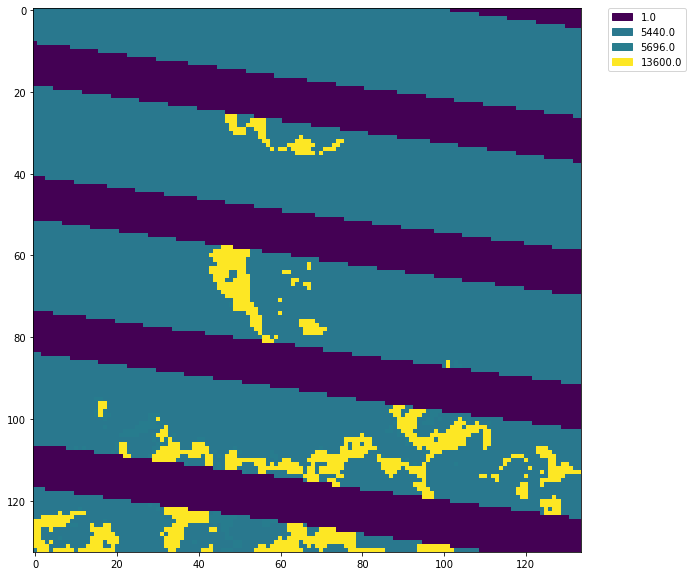

In [9]:
import stackstac
import pystac_client
import pyproj
import planetary_computer as pc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

lat, lon =  -5, 20

catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

search = catalog.search(
    collections=['landsat-c2-l2'],
    intersects=dict(type="Point", coordinates=[lon, lat]),
    datetime="2020-12-01/2021-01-01",
    query={"eo:cloud_cover": {"lt": 25}}
)

items = pc.sign(search)

stack = stackstac.stack(items, assets=["qa_pixel"])

x_utm, y_utm = pyproj.Proj(stack.crs)(lon, lat)

buffer = 2000  # meters

aoi = stack.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]

image = aoi.data.squeeze().compute()

plt.figure(figsize=(10,10))
im = plt.imshow(image, interpolation='none')
values = np.unique(image.ravel())
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{values[i]}") for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

In [10]:
stack['raster:bands']

<xarray.DataArray 'raster:bands' ()>
array({'unit': 'bit index', 'nodata': 1, 'data_type': 'uint16', 'spatial_resolution': 30},
      dtype=object)
Coordinates: (12/24)
    landsat:cloud_cover_land     float64 24.0
    landsat:scene_id             <U21 'LE71790632020344SG100'
    created                      <U27 '2022-05-06T17:58:41.287629Z'
    instruments                  <U4 'etm+'
    sci:doi                      <U16 '10.5066/P9C7I13B'
    gsd                          int64 30
    ...                           ...
    landsat:collection_category  <U2 'T2'
    eo:cloud_cover               float64 24.0
    view:sun_elevation           float64 50.94
    title                        <U29 'Pixel Quality Assessment Band'
    raster:bands                 object {'unit': 'bit index', 'nodata': 1, 'd...
    epsg                         int64 32634

In [85]:
dataset = CustomDataset(points, matching_items, buffer = 2)

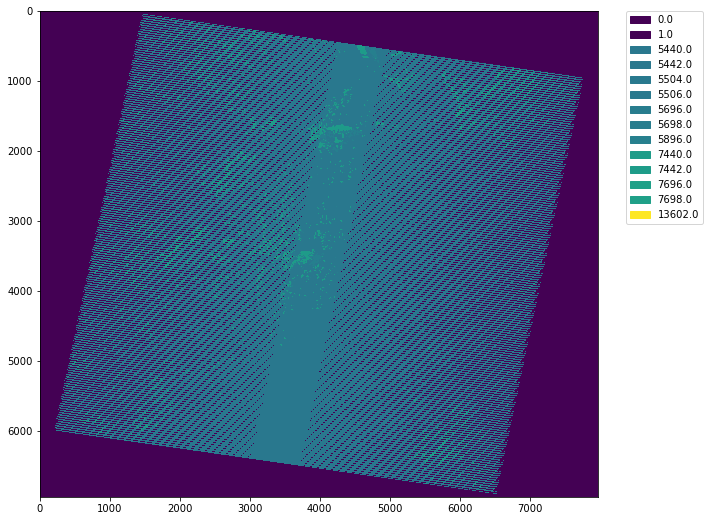

In [86]:

import matplotlib.patches as mpatches
img = dataset[0]
plt.figure(figsize=(10,10))
im = plt.imshow(img, interpolation='none')

# get the unique values from data
# i.e. a sorted list of all values in data
values = np.unique(img.ravel())

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=f"{values[i]}") for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


plt.show()
plt.close()

In [80]:
img

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.4400e+03, 5.4400e+03,
         5.4400e+03],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.4400e+03, 5.4400e+03,
         5.4400e+03],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.4400e+03, 5.4400e+03,
         5.4400e+03],
        ...,
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.4400e+03, 5.4400e+03,
         5.4400e+03],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.4400e+03, 5.4400e+03,
         5.4400e+03],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.4400e+03, 5.4400e+03,
         5.4400e+03]])

In [18]:
na_perc = ((img.isnan()).sum() / img.numel()).item()
na_perc

0.4290935695171356

In [19]:
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=workers,
    collate_fn=lambda x: x,
    pin_memory=False,
    persistent_workers=False,
)

In [20]:
%%time
print("Collecting metadata: ", month, "-", yr, sep = "")

x_all = np.zeros((points.shape[0], 1), dtype=float)
tic = time.time()
i = 0
for images in dataloader:
    for image in images:
        if i % 500 == 0:
            print(
                f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
                + f" -- {time.time()-tic:0.2f} seconds"
            )
            tic = time.time()
            
        x_all[i] = ((image.isnan()).sum() / image.numel()).item()
        
        i += 1

0/2629 -- 0.00% -- 0.52 seconds
500/2629 -- 19.02% -- 23.09 seconds
1000/2629 -- 38.04% -- 281.37 seconds
1500/2629 -- 57.06% -- 20.62 seconds
2000/2629 -- 76.07% -- 286.55 seconds
2500/2629 -- 95.09% -- 23.12 seconds
CPU times: user 1.67 s, sys: 481 ms, total: 2.15 s
Wall time: 10min 41s


In [21]:
x_all

array([[0.42909357],
       [0.35599416],
       [0.50525528],
       ...,
       [0.36336336],
       [0.4496997 ],
       [0.36786786]])

In [22]:
x_all.min()

0.0

In [23]:
x_all.max()

0.8738738894462585

In [24]:
x_all.mean()

0.25719277062533924

In [79]:
df3 = df2.dropna(subset=["stac_item"]).reset_index(drop = True)

In [80]:
df3['stac_item'].apply(pd.Series)['properties']

0       {'gsd': 30, 'created': '2022-05-06T16:52:23.73...
1       {'gsd': 30, 'created': '2022-05-06T16:52:23.73...
2       {'gsd': 30, 'created': '2022-05-06T16:52:23.73...
3       {'gsd': 30, 'created': '2022-05-06T16:52:23.73...
4       {'gsd': 30, 'created': '2022-05-06T17:20:31.65...
                              ...                        
2624    {'gsd': 30, 'created': '2022-05-06T16:52:23.73...
2625    {'gsd': 30, 'created': '2022-05-06T16:52:23.73...
2626    {'gsd': 30, 'created': '2022-05-06T16:52:23.73...
2627    {'gsd': 30, 'created': '2022-05-06T16:52:23.73...
2628    {'gsd': 30, 'created': '2022-05-06T16:52:23.73...
Name: properties, Length: 2629, dtype: object

In [81]:
df3['stac_id'] = df3['stac_item'].apply(pd.Series)['id']
df3['platform'] = df3['stac_item'].apply(pd.Series)['properties'].apply(pd.Series)['platform']
df3['cloud_cover'] = df3['stac_item'].apply(pd.Series)['properties'].apply(pd.Series)['eo:cloud_cover']
df3.drop(['geometry', 'hd', 'stac_item'], axis = 1, inplace = True)
df3[['na_percent', 'year', "month"]] = x_all, yr, mn
df3 = pd.DataFrame(df3)
df3

,crop_perc,lon,lat,stac_id,platform,cloud_cover,na_percent,year,month
0,0.177870,30.654878,-13.154232,LE07_L2SP_170069_20090110_02_T1,landsat-7,6.0,0.429094,2009,1
1,0.168947,30.644878,-13.094232,LE07_L2SP_170069_20090110_02_T1,landsat-7,6.0,0.355994,2009,1
2,0.157644,30.624878,-12.934232,LE07_L2SP_170069_20090110_02_T1,landsat-7,6.0,0.505255,2009,1
3,0.217133,30.634878,-12.914232,LE07_L2SP_170069_20090110_02_T1,landsat-7,6.0,0.388138,2009,1
4,0.639500,28.464878,-9.304232,LE07_L2SP_172066_20090108_02_T1,landsat-7,6.0,0.340394,2009,1
...,...,...,...,...,...,...,...,...,...
2624,0.224866,30.644878,-13.194232,LE07_L2SP_170069_20090110_02_T1,landsat-7,6.0,0.460902,2009,1
2625,0.255205,30.644878,-13.184232,LE07_L2SP_170069_20090110_02_T1,landsat-7,6.0,0.374269,2009,1
2626,0.262939,30.624878,-13.214232,LE07_L2SP_170069_20090110_02_T1,landsat-7,6.0,0.363363,2009,1
2627,0.160024,30.634878,-13.204232,LE07_L2SP_170069_20090110_02_T1,landsat-7,6.0,0.449700,2009,1


In [90]:
fn = f'{satellite}_{country_code}_{pt_len/1000:.0f}k-points_meta_{yr}_{mn}.csv'
file_name = here('data', 'random_features', satellite, fn)
fn

'landsat-c2-l2_ZMB_20k-points_meta_2009_1.csv'